In [5]:
import numpy as np

In [45]:
sex_ratio = 0.5
initial_ratio_of_two_species = 0.5
initial_total_population_size = 10
size_attractiveness_coefficient_female = 10
size_attractiveness_coefficient_male = 1
emergence_time_coeff = 5
mean_death_time = 20

mean_size_population_A = 0.3
mean_size_population_B = 0.7

std_deviation_size = 0.2

trackmatings = 20



In [7]:
total_population_size = initial_total_population_size
ratio_of_two_species = initial_ratio_of_two_species

In [37]:
sizes_A = np.round(np.random.normal(loc=mean_size_population_A, scale=std_deviation_size, size=total_population_size), 4)
sizes_B = np.round(np.random.normal(loc=mean_size_population_B, scale=std_deviation_size, size=total_population_size), 4)

# Ensure sizes are within bounds [0, 1]
sizes_A = np.clip(sizes_A, 0.05, 1)
sizes_B = np.clip(sizes_B, 0.05, 1)

# Population species array
population_species_array = np.random.choice(['A', 'B'], size=total_population_size, p=[ratio_of_two_species, 1 - ratio_of_two_species])

# Population size array
population_size_array = np.where(population_species_array == 'A', sizes_A, sizes_B)

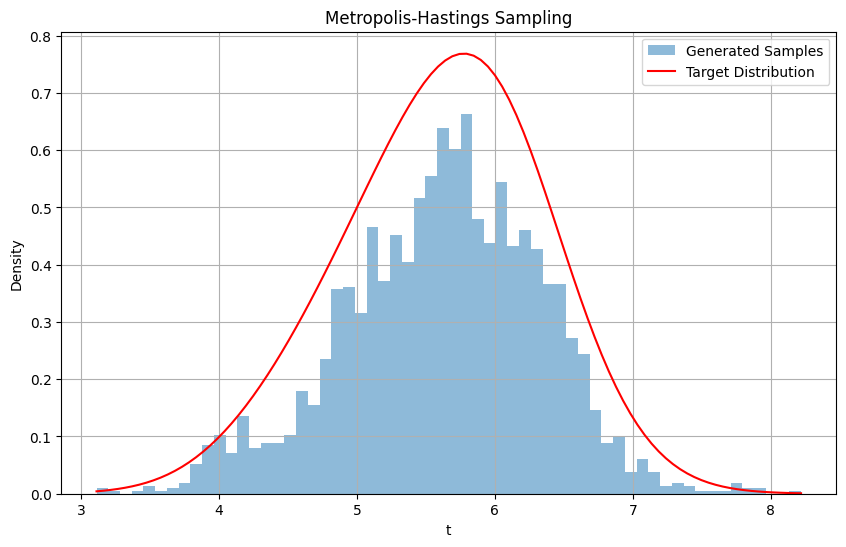

In [15]:
import matplotlib.pyplot as plt

def target_distribution(t, T):
    return np.exp(t - T) / (1 + np.exp((t - T)**2))

def gaussian_proposal(current_t, proposal_sd):
    return np.random.normal(current_t, proposal_sd)

def metropolis_hastings(T, num_samples, num_iterations, proposal_sd=1.0):
    samples = []
    current_t = 0  # Initial starting point, you can choose any value
    
    for _ in range(num_iterations):
        proposed_t = gaussian_proposal(current_t, proposal_sd)
        
        acceptance_prob = min(1, target_distribution(proposed_t, T) / target_distribution(current_t, T))
        if np.random.uniform() < acceptance_prob:
            current_t = proposed_t
        
        samples.append(current_t)
        
    return samples[-num_samples:]

# Example usage:
T_ = emergence_time_coeff
num_samples = 2500
num_iterations = 10000
proposal_sd = 1.0  # Standard deviation for the Gaussian proposal distribution
emergence_samples = metropolis_hastings(T_, num_samples, num_iterations, proposal_sd)

# Plotting
plt.figure(figsize=(10, 6))

# Plot histogram of generated samples
plt.hist(emergence_samples, bins=60, density=True, alpha=0.5, label='Generated Samples')

# Plot target distribution
t_values = np.linspace(min(emergence_samples), max(emergence_samples), 100)
plt.plot(t_values, target_distribution(t_values, T_), color='red', label='Target Distribution')

plt.title('Metropolis-Hastings Sampling')
plt.xlabel('t')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
#population size sex array 
population_sex_array = np.random.choice(['M', 'F'], size= initial_total_population_size)
population_species_array = np.random.choice(['A', 'B'], size= total_population_size, p=[ratio_of_two_species, 1 - ratio_of_two_species])

emergence_time_arrays = np.random.choice(emergence_samples, size = initial_total_population_size)
death_time_arrays = emergence_time_arrays + np.random.exponential(mean_death_time, initial_total_population_size)

print(emergence_time_arrays)
print(death_time_arrays)

female_indices = np.where(np.array(population_sex_array) == 'F')[0]
male_indices = np.where(np.array(population_sex_array) == 'M')[0]
species_A_indices = np.where(np.array(population_species_array) == 'A')[0]
species_B_indices = np.where(np.array(population_species_array) == 'B')[0]

print(species_A_indices)

[6.31137102 6.44403408 5.8865598  6.31137102 7.01036268 5.23919866
 6.79292171 5.36046996 4.35908367 5.76758838]
[ 37.4893419   20.68266805  15.72440342  16.60549824 189.56641471
  14.32916453  36.21228139  97.22475317  13.23171024  62.85845167]
[False False False  True False False False False False  True]


In [123]:
T_encounter = np.zeros((trackmatings, total_population_size)) #grand list, all potnetial times of encounter arranged in time ascengding order
who_encounter = np.zeros((trackmatings, total_population_size)) #grand list, all potential mlaes for each female arranged in 

for i in range(len(population_size_array)):
    if female_indices[i]:

        
        attractiveness_of_female_in_the_eyes_of_A_males = size_attractiveness_coefficient_female*(1 - population_size_array[i]) #A prefers small


        attractiveness_of_female_in_the_eyes_of_B_males = size_attractiveness_coefficient_female*population_size_array[i] 


        
        #B prefers big
        
        t_encounter_for_given_female = np.zeros(len(population_size_array))
        t_encounter_for_given_female[species_A_indices] = emergence_time_arrays[species_A_indices] + np.random.exponential(attractiveness_of_female_in_the_eyes_of_A_males, size = np.sum(species_A_indices))
        t_encounter_for_given_female[species_B_indices] = emergence_time_arrays[species_B_indices] + np.random.exponential(attractiveness_of_female_in_the_eyes_of_B_males, size = np.sum(species_B_indices))
        t_encounter_for_given_female[female_indices] = np.nan
        t_encounter_for_given_female[t_encounter_for_given_female > death_time_arrays[i]] = np.nan  # if the female died before the encounter, the encounter never happened
        t_encounter_for_given_female[male_indices][(t_encounter_for_given_female[male_indices] > death_time_arrays[male_indices])] = np.nan


        nan_mask = np.logical_and(~np.isnan(t_encounter_for_given_female), t_encounter_for_given_female != 0)
        # t_encounter_filtered = t_encounter_for_given_female[nan_mask]
        number_of_actual_matings =np.sum(nan_mask)

        sorted_indices_full = np.argsort(t_encounter_for_given_female)
        sorted_indices_actual_matings = sorted_indices_full[:number_of_actual_matings]


        # Apply the sorted indices to the filtered arrays
        sorted_t_encounter = t_encounter_for_given_female[sorted_indices_actual_matings]
        sorted_whichmale = sorted_indices_actual_matings[:trackmatings]

        # Update the original arrays with sorted values
    
        T_encounter[:len(sorted_t_encounter), i] = sorted_t_encounter
        who_encounter[:len(sorted_t_encounter), i] = sorted_whichmale

        # print(T_encounter[:, i])

        if len(sorted_t_encounter) > trackmatings:
            T_encounter[:, i] = sorted_t_encounter[:trackmatings]
            who_encounter[:, i] = sorted_whichmale[:trackmatings]


        
print(T_encounter)
print(female_indices)

[[ 0.          7.3381703   5.383551    5.91733916  8.78780603  0.
   0.          8.82024004  5.46261126  6.79113415]
 [ 0.         11.88880385  7.10058749  6.9199639  15.3796656   0.
   0.         10.03538876  8.93596289  9.01797383]
 [ 0.          0.          7.33069836  8.79035595 29.77456255  0.
   0.         14.90954338 13.1963835  15.27242932]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0

In [101]:
t_encounter = T_encounter[1,:]
print(t_encounter)

t_encounter[species_A_indices and female_indices] = t_encounter[species_A_indices] + 1
print(t_encounter)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()